In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc, roc_auc_score, precision_score, recall_score, f1_score

In [2]:
raw_df = pd.read_csv('data.csv')
print(raw_df.shape)

(11914, 16)


- use the following columns: Make, Model, Year, Engine HP, Engine Cylinders, Transmission Type, Vehicle Style, highway MPG, city mpg, MSRP

### Data preparation
- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [3]:
req_cols = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 
            'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = raw_df[req_cols].copy()
df.columns = ['_'.join(c.lower().split()) for c in df.columns]
df.fillna(0, inplace=True)

In [4]:
avg_price = df['msrp'].mean()
df['above_average'] = np.where(df['msrp'] > avg_price, 1, 0)

In [6]:
x_train_all, x_test, y_train_all, y_test = train_test_split(
    df.drop(columns=['above_average', 'msrp']),
    df[['above_average']], test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=0.25, random_state=1)
print(x_train.shape, x_val.shape, x_test.shape)

(7148, 9) (2383, 9) (2383, 9)


### Question 1: ROC AUC feature importance
- ROC AUC could also be used to evaluate feature importance of numerical variables.
- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that
- If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['engine_hp'])
- AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
- Which numerical variable (among the following 4) has the highest AUC?
  - engine_hp
  - engine_cylinders
  - highway_mpg
  - city_mpg

In [7]:
result_df = []
for col in x_train.select_dtypes(include='number').columns:
    auc = roc_auc_score(y_train['above_average'], x_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train['above_average'], -x_train[col])
    result_df.append((col, auc))
result_df = pd.DataFrame(result_df, columns=['column', 'roc_auc_score'])
cond = result_df['column'].isin(['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg'])
result_df[cond].sort_values('roc_auc_score', ascending=False).head(1)

,column,roc_auc_score
1,engine_hp,0.917103


### Question 2: Training the model
- Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- What's the AUC of this model on the validation dataset? (round to 3 digits)
  - 0.678
  - 0.779
  - 0.878
  - 0.979

In [8]:
dv = DictVectorizer(sparse=False)
x_train_df = dv.fit_transform(x_train.to_dict(orient='records'))
x_val_df = dv.transform(x_val.to_dict(orient='records'))

In [10]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(x_train_df, np.ravel(y_train))
yval_pred = lr.predict_proba(x_val_df)[:, 1]
score = roc_auc_score(y_true=y_val, y_score=yval_pred)
print('AUC of model: {:.3f}'.format(score))

AUC of model: 0.979


### Question 3: Precision and Recall
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
- At which threshold precision and recall curves intersect?
  - 0.28
  - 0.48
  - 0.68
  - 0.88

In [11]:
threshold_ls = np.arange(0, 1.01, 0.01)
result_df = []
for val in threshold_ls:
    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    lr.fit(x_train_df, np.ravel(y_train))
    yval_pred = lr.predict_proba(x_val_df)[:, 1]
    prec = precision_score(y_true=y_val, y_pred = yval_pred >= val)
    recall = recall_score(y_true=y_val, y_pred = yval_pred >= val)
    result_df.append((val, prec, recall))
result_df = pd.DataFrame(result_df, columns=['threshold', 'precision', 'recall'])

/home/byl/Documents/byl/studies/MLZoomCamp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: xlabel='threshold'>

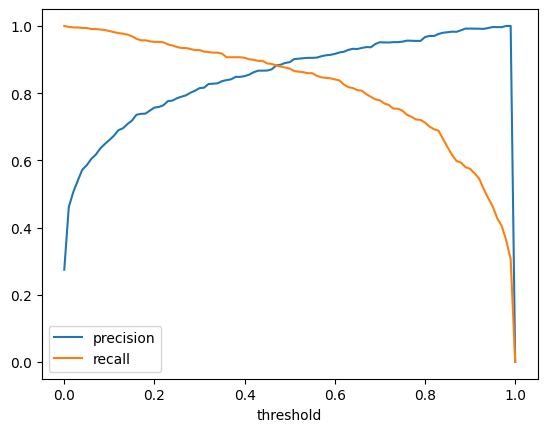

In [12]:
ax = result_df.plot(x='threshold', y='precision')
result_df.plot(x='threshold', y='recall', ax=ax)

In [14]:
cond = result_df['precision'] == result_df['recall']
result_df[cond]

,threshold,precision,recall
47,0.47,0.882263,0.882263
100,1.00,0.000000,0.000000


### Question 4: F1 score
- This is the formula for computing F1: $F_1 = 2 * \frac{P  R}{P + R}$ where P is precision and R is recall.
- Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
- At which threshold F1 is maximal?
  - 0.12
  - 0.32
  - 0.52
  - 0.72

In [15]:
threshold_ls = np.arange(0, 1.01, 0.01)
result_df = []
for val in threshold_ls:
    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    lr.fit(x_train_df, np.ravel(y_train))
    yval_pred = lr.predict_proba(x_val_df)[:, 1]
    prec = precision_score(y_true=y_val, y_pred = yval_pred >= val)
    recall = recall_score(y_true=y_val, y_pred = yval_pred >= val)
    f1_score = 2 * prec * recall / (prec + recall)
    result_df.append((val, prec, recall, f1_score))
result_df = pd.DataFrame(result_df, columns=['threshold', 'precision', 'recall', 'f1_score'])

/home/byl/Documents/byl/studies/MLZoomCamp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_13480/2841451566.py:9: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * prec * recall / (prec + recall)


In [16]:
result_df.sort_values('f1_score', ascending=False).head(1)

,threshold,precision,recall,f1_score
51,0.51,0.901274,0.865443,0.882995


### Question 5: 5-Fold CV
- Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds: `KFold(n_splits=5, shuffle=True, random_state=1)`
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation
- How large is standard devidation of the scores across different folds?
  - 0.003
  - 0.030
  - 0.090
  - 0.140

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [18]:
result_df = [] 
i = 0
for train_idx, val_idx in kfold.split(df_full_train):
    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    dv = DictVectorizer(sparse=False)
    x_train_df = df_full_train.iloc[train_idx, :].drop(
        columns=['msrp', 'above_average'])
    y_train_df = df_full_train.iloc[train_idx, :]['above_average'].copy()
    x_val_df = df_full_train.iloc[val_idx, :].drop(
        columns=['msrp', 'above_average'])
    y_val_df = df_full_train.iloc[val_idx, :]['above_average'].copy()
    x_train_df = dv.fit_transform(x_train_df.to_dict(orient='records'))
    x_val_df = dv.transform(x_val_df.to_dict(orient='records'))
    lr.fit(x_train_df, y_train_df)
    ypred = lr.predict_proba(x_val_df)[:, 1]
    score = roc_auc_score(y_true=y_val_df, y_score=ypred)
    i = i + 1
    result_df.append((i, score))
result_df = pd.DataFrame(result_df, columns=['fold', 'roc_auc_score'])

In [22]:
print('Standard deviation of the scores across different folds: {:.3f}'.format(
    np.std(result_df['roc_auc_score'])))

Standard deviation of the scores across different folds: 0.003


### Question 6: Hyperparemeter Tuning
- Use 5-Fold cross-validation to find the best parameter C
- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
- Which C leads to the best mean score? If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.
  - 0.01
  - 0.1
  - 0.5
  - 10

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [24]:
result_df = [] 
c_list = [0.01, 0.1, 0.5, 10]
for c in c_list:
    score_list = []
    for train_idx, val_idx in kfold.split(df_full_train):
        lr = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        dv = DictVectorizer(sparse=False)
        x_train_df = df_full_train.iloc[train_idx, :].drop(
            columns=['msrp', 'above_average'])
        y_train_df = df_full_train.iloc[train_idx, :]['above_average'].copy()
        x_val_df = df_full_train.iloc[val_idx, :].drop(
            columns=['msrp', 'above_average'])
        y_val_df = df_full_train.iloc[val_idx, :]['above_average'].copy()
        x_train_df = dv.fit_transform(x_train_df.to_dict(orient='records'))
        x_val_df = dv.transform(x_val_df.to_dict(orient='records'))
        lr.fit(x_train_df, y_train_df)
        ypred = lr.predict_proba(x_val_df)[:, 1]
        score = roc_auc_score(y_true=y_val_df, y_score=ypred)
        score_list.append(score)
    result_df.append((c, np.round(np.mean(score_list), 3), np.round(np.std(score_list), 3)))
result_df = pd.DataFrame(result_df, columns=['C_value', 'mean_roc_auc', 'std_roc_auc'])

In [25]:
result_df.sort_values(['mean_roc_auc', 'std_roc_auc', 'C_value'], ascending=[False, True, True]).head(1)

,C_value,mean_roc_auc,std_roc_auc
3,10.0,0.981,0.003
